In [8]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV, cross_validate, RepeatedKFold
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor, make_column_transformer
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier

**Crear el pipeline de ML (con transformers y estimators) para dar un resultado**

In [9]:
#Leemos el dataset

df = pd.read_csv('/content/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


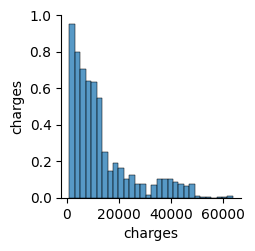

In [10]:
#Vemos como funciona la variable charges

sns.pairplot(df[["charges"]])

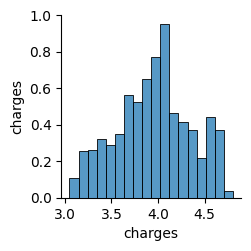

In [11]:
#Lea plicamos logaritmos en base 10 para transformar la variable y que el ML lo entienda mejor

sns.pairplot(np.log10(df[['charges']]))

In [12]:
#Vemos la información general del dataset, con la cantidad de valore nulos y el type de cada columna

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [13]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [14]:
#Separamos las variables en x e y. La "x" son las variables que nos ayudan a predecir el valor y la "y" es la variable dependiente

x, y = df.drop(["charges"], axis = 1), df["charges"]

In [15]:
#Separamos en train y test para entrenar, testear y poder predecir el modelo luego.

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42)

In [16]:
#Realizamos un preprocesador, donde se le indican columans con infomración y te realiza cierta acción.
#A las variable categóricas le realizamos un OneHotEncoder donde se transforma una variable de texto en ceros y unos para ayudar al sistema de ML.

categorical_columns = ["sex", "smoker", "region"]
numerical_columns = ["age", "bmi", "children"]

preprocessor = make_column_transformer((OneHotEncoder(drop = "if_binary"), categorical_columns),
                                       remainder = "passthrough",
                                       verbose_feature_names_out = False,)

In [17]:
#Creamos un pipeline que usa el preprocesador previo y el TransformesTarget Regressor con regressor "Ridge" para poder predecir el valor

model = make_pipeline(preprocessor,
                      TransformedTargetRegressor(regressor = Ridge (alpha = 1e-10), func = np.log10, inverse_func = sp.special.exp10),)

In [18]:
#Entrenamos el modelo con el comando "fit" para que entienda como se calcula el valor utilizando los parámetros de entrenamiento

model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['sex', 'smoker', 'region'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

In [19]:
#Vamos a realizar ciertas predicciones en la variable "y_pred" sobre los datos de entrenamiento y prueba.
#Vamos a aplicar el MAE para ver que tan bien está siendo el modelo y se crea una cadena de texto para mostrar dicho valor MAE.

y_pred = model.predict(X_train)

mae = median_absolute_error(y_train, y_pred)
string_score = f"MAE on training set: {mae: 2f} euros"

y_pred = model.predict(X_test)

mae = median_absolute_error(y_test, y_pred)
string_score += f"\nMAE on testing set: {mae: 2f} euros"

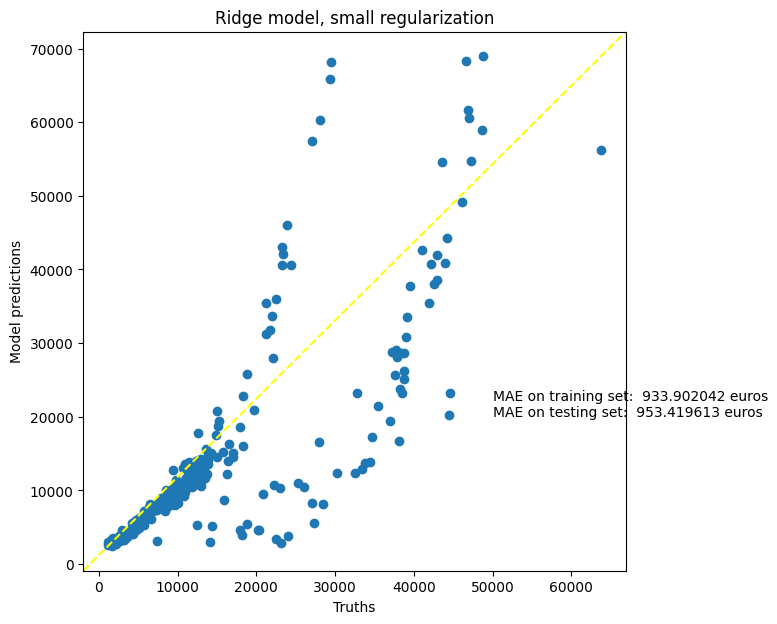

In [20]:
fig, ax = plt.subplots(figsize = (7, 7))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform = ax.transAxes, ls = "--", c = "yellow")
plt.text(50000, 20000, string_score)
plt.title("Ridge model, small regularization")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.show()

Analizando los resultados de la predicción del modelo, podemos observar ciertos valores en los que difiere según el conjunto de datos.
Para el caso del conjunto de datos de entrenamiento, las predicciones del modelo difieren en un monto de 933.902042 euros en promedio con respecto a los valores reales.
Mientras que para el conjunto de datos de prueba, las predicciones difieren en promedio 953.419613 euros con respecto a los valores reales.

In [21]:
#Analizamos los coeficientes y vemos cuanto aporta cada variable en la predicción del valor del seguro.

feature_names = model[:-1]. get_feature_names_out()

coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns = ["Coefficients"],
    index = feature_names)

coefs

,Coefficients
sex_male,-0.032023
smoker_yes,0.671235
region_northeast,0.034845
region_northwest,0.009644
region_southeast,-0.026922
region_southwest,-0.017383
age,0.015050
bmi,0.005766
children,0.041345


Como principial coeficiente que tiene un alto impacto en el precio del seguro es en la variable de si la persona fuma o no.

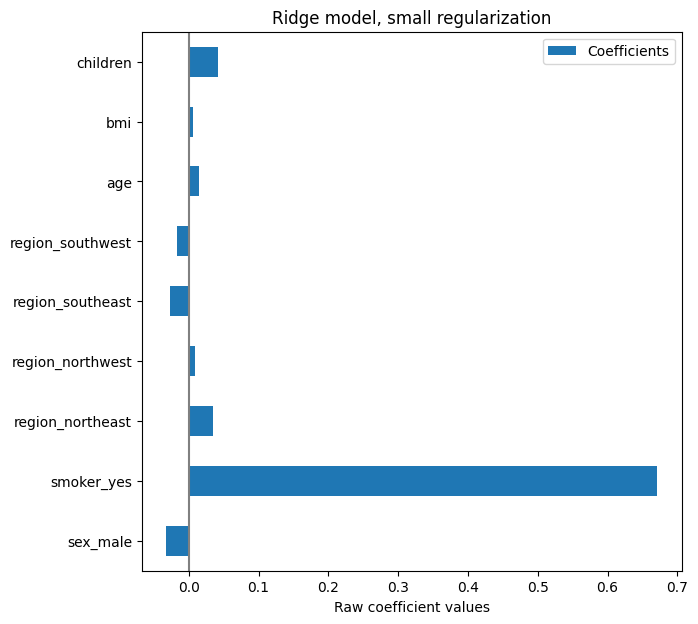

In [22]:
#pasamos a ver los coeficientes en formato de barras horizontales, para poder visualizar la importancia relativa de cada variable de una forma mas visual

coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x = 0, color = ".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left = 0.3)

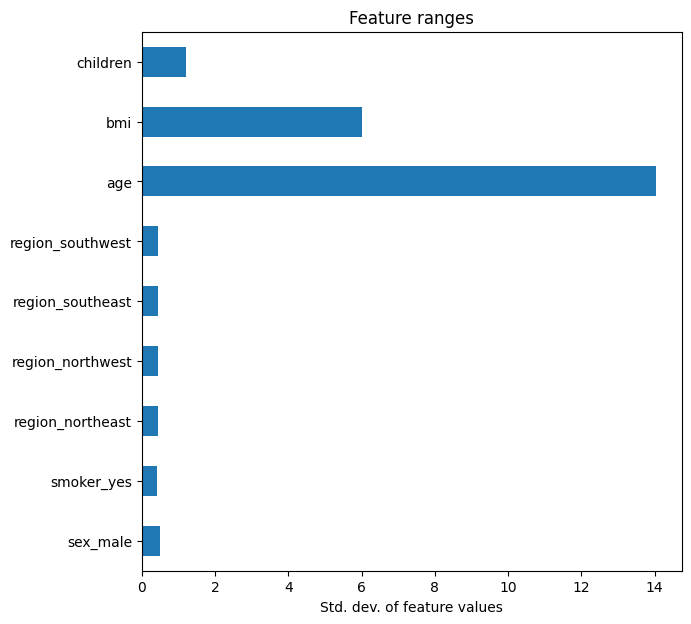

In [23]:
#Creamos otro gráfico de barras horizontales, donde identificamos la varianza en cada una de las variables en el conjunto de entrenamiento preprocesado
#Cuanto mayor la barra, mayor la varianza de la variable

X_train_preprocessed = pd.DataFrame(model[:1].transform(X_train), columns = feature_names)

X_train_preprocessed.std(axis = 0).plot.barh(figsize = (9, 7))
plt.title("Feature ranges")
plt.xlabel("Std. dev. of feature values")
plt.subplots_adjust(left = 0.3)

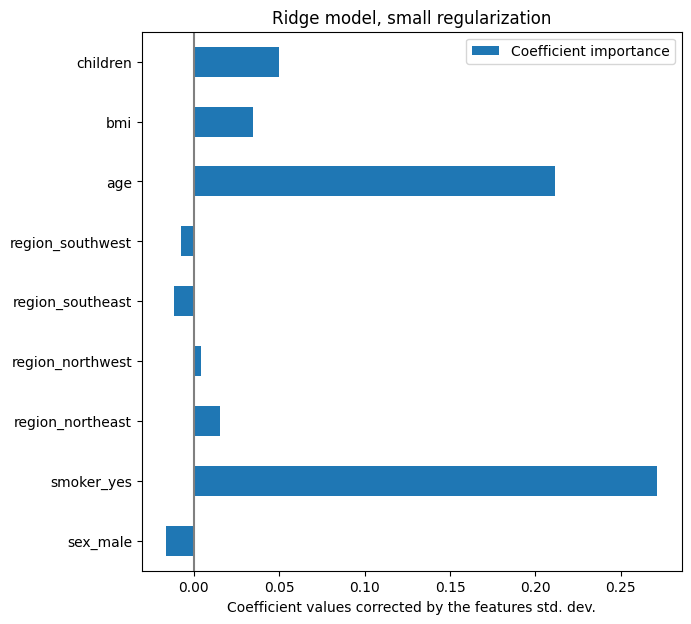

In [24]:
#procedemos a corregir las varianzas de las variables para poder ver mucho mejor la importancia de cada variable.

coefs = pd.DataFrame(model[-1].regressor_.coef_ * X_train_preprocessed.std(axis = 0), columns = ["Coefficient importance"], index = feature_names)
coefs.plot(kind = "barh", figsize = (9, 7 ))
plt.xlabel("Coefficient values corrected by the features std. dev.")
plt.title("Ridge model, small regularization")
plt.axvline(x = 0, color = ".5")
plt.subplots_adjust(left = 0.3)

In [25]:
#Utilizamos a continuación la técnica de Cross Validation, ya que queremos repetir lo hecho anteriormente para varias separaciones de nuestro datos para lograr mejores resultados en nuestro análisis

cv = RepeatedKFold(n_splits = 5, n_repeats = 5, random_state = 0)
cv_model = cross_validate(
    model,
    x,
    y,
    cv = cv,
    return_estimator = True,
    n_jobs = 2)

coefs = pd.DataFrame(
    [
        est[-1].regressor_.coef_
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(x, y))
    ],
    columns = feature_names)

coefs


,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age,bmi,children
0,-0.022274,0.678699,0.034504,0.011293,-0.028223,-0.016470,0.015081,0.006135,0.042513
1,-0.032437,0.657186,0.045999,0.007801,-0.036774,-0.017616,0.015068,0.006165,0.045869
2,-0.034872,0.678707,0.037145,0.012727,-0.030392,-0.018762,0.014438,0.006508,0.041976
3,-0.037449,0.676605,0.036712,0.010640,-0.027553,-0.020348,0.015316,0.005623,0.047211
4,-0.036527,0.684670,0.035745,0.008775,-0.028157,-0.016498,0.015205,0.004552,0.043439
5,-0.020575,0.671365,0.038282,0.003324,-0.030651,-0.011046,0.014900,0.005359,0.041673
6,-0.036975,0.682932,0.047443,0.009310,-0.034042,-0.021817,0.014931,0.006963,0.043065
7,-0.035531,0.656864,0.039919,0.017638,-0.027994,-0.028972,0.015204,0.005613,0.045255
8,-0.035005,0.683486,0.036770,0.007685,-0.025741,-0.018340,0.014920,0.004652,0.045196
9,-0.034959,0.678950,0.028606,0.013506,-0.032443,-0.010320,0.015176,0.006309,0.046243


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


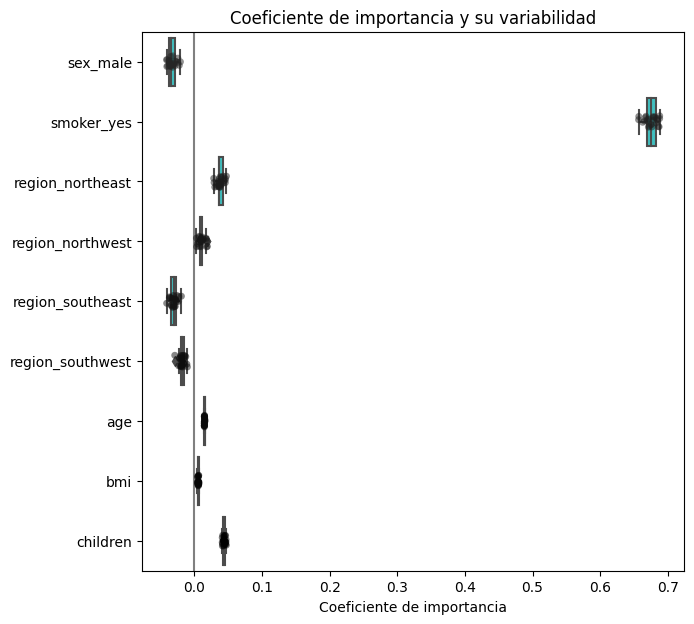

In [26]:
#Creamos un nuevo gráfico, donde vamos a ver la importancia relativa de los coeficientes del modelo con el cross validation.

plt.figure(figsize = (7,7))
sns.stripplot(data = coefs, orient = "h", color = "k", alpha = 0.5)
sns.boxplot(data = coefs, orient = "h", color = "cyan", saturation = 0.5)
plt.axvline(x = 0, color = "0.5")
plt.title("Coeficiente de importancia y su variabilidad")
plt.xlabel("Coeficiente de importancia")
plt.show()

**Empaquetar el algoritmo**

Identificamos en el gráfico anterior, que el ser fumador o no es la variable más relevante y por ende el más importante.

In [27]:
import pickle

In [28]:
with open('model.pkl', 'wb') as file:
  pickle.dump(model, file)

In [29]:
with open('model.pkl', 'rb') as file:
  model = pickle.load(file)

**Disponibilizar el algoritmo como API utilizando Flask dentro de un Contenedor y subirlo a
Docker**

In [31]:
from flask import Flask, request, jsonify

#Inciciamos la aplicación Flask y definimos la ruta y el método para hacer la predicción
app = Flask(__name__)
@app.route('/predict', methods=['POST'])

def predict():
    data = request.json
    prediction = model.predict([data['features']])
    response = {'prediction': prediction.tolist()}
    return jsonify(response)

if __name__ == '_main_':
  app.run()

**Crear un entorno tox de pruebas dentro del repositorio que se empaquetó**

In [47]:
!pip install tox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
!pip install pytest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
!tox

py3: commands[0]> pytest
============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-7.3.2, pluggy-1.0.0
cachedir: .tox/py3/.pytest_cache
rootdir: /content
collected 1 item                                                               

test_example.py .                                                        [100%]

============================== 1 passed in 0.01s ===============================
  py3: OK (0.52=setup[0.10]+cmd[0.41] seconds)
  congratulations :) (0.64 seconds)
